# 셸로우 포커스 모델 만들기

## 1. 인물사진

In [1]:
import cv2
import os
import tarfile
import urllib
import numpy as np
import tensorflow as tf

from glob import glob
from os.path import join
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편할게 사용할 수 있는 라이브러리

(412, 550, 3)


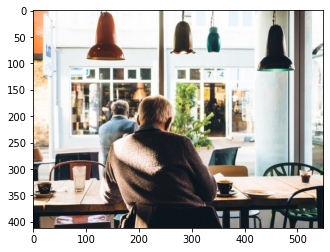

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cafe.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# PixelLib에서 제공해주는 모델 다운로드
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다#
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa304d6f3d0>)

In [4]:
# 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

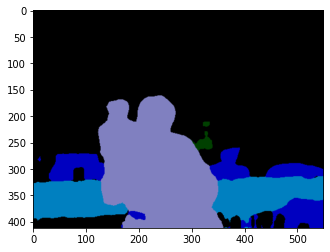

In [7]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  9, 11, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
diningtable
person
pottedplant


In [10]:
# PixelLib에서 그대로 가져온 코드입니다
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.
seg_color = (128,128,192)

(412, 550)


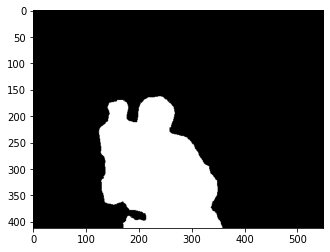

In [12]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

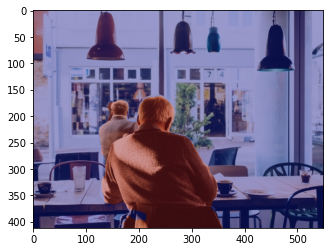

In [13]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

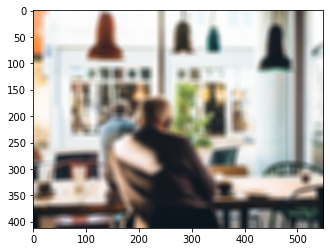

In [14]:
# 이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

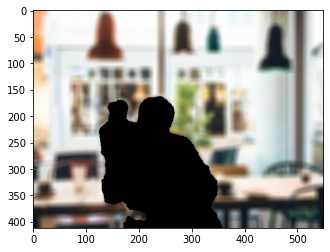

In [15]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

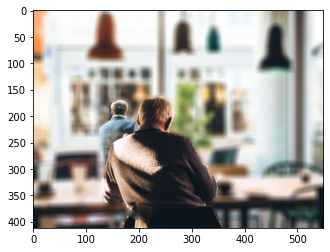

In [16]:
# 배경여상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 1
* 뒤에 있는 사람도 같이 인식됨 

(888, 1200, 3)


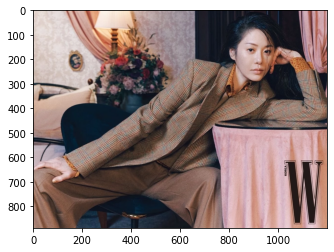

In [92]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/go.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [93]:
# 모델 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

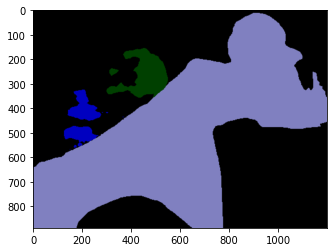

In [94]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [95]:
segvalues

{'class_ids': array([ 0,  9, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [96]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
pottedplant


In [97]:
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.
seg_color = (128,128,192)

(888, 1200)


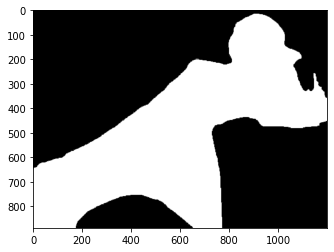

In [98]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

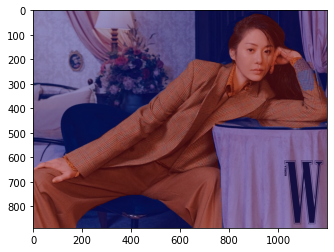

In [99]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

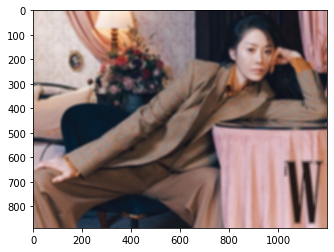

In [100]:
# 이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

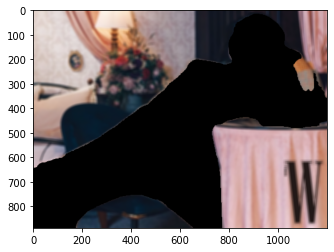

In [101]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

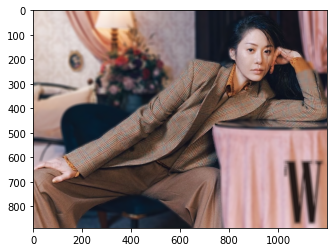

In [102]:
# 배경여상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 2
* 소매 부분 인식이 잘 안되는 현상이 나타남

## 2. 동물 사진(고양이)

(251, 201, 3)


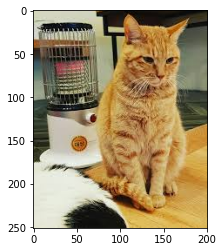

In [111]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [112]:
# 모델 이미지 입력하기
segvalues, output = model.segmentAsPascalvoc(img_path)

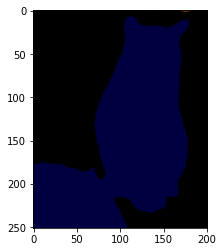

In [113]:
# 모델에서 나온 출력값 보기
plt.imshow(output)
plt.show()

In [114]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat
tv


In [118]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [129]:
#PixelLib에 따르면 위와 같은 색을 사용했다고 하네요
colormap[8]

array([64,  0,  0])

In [130]:
#우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.
seg_color = (0,0,64)

(251, 201)


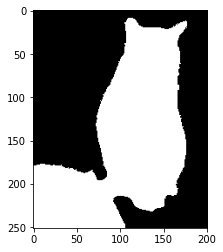

In [131]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

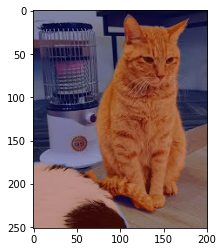

In [132]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

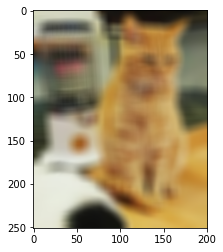

In [133]:
# 이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.
# (13,13)은 blurring kernel size를 뜻합니다

img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

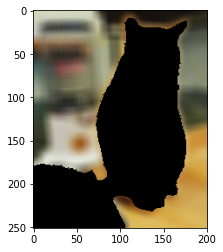

In [134]:
#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

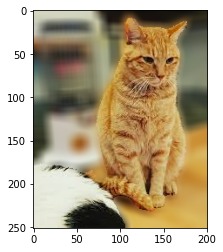

In [135]:
# 배경여상과 사람 영상을 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 동물 사진 셸로우 포커스 문제점
* 고양이 경계선 부분이 정확하지 않음

## 3. 크로마키 사진

In [142]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.png'  
img_bg = cv2.imread(img_path) 

print (img_bg.shape)

(393, 700, 3)


In [143]:
target_size = img_orig.shape[:2][::-1]
resized_bg = cv2.resize(img_bg, target_size)
print(resized_bg.shape)

(251, 201, 3)


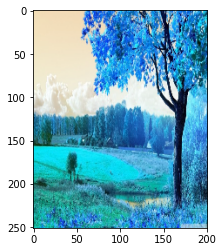

In [144]:
plt.imshow(resized_bg)
plt.show()

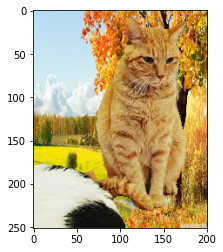

In [145]:
img_concat = np.where(img_mask_color==255, img_orig, resized_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## semantic segmentation mask의 오류를 보완 방법들 제시

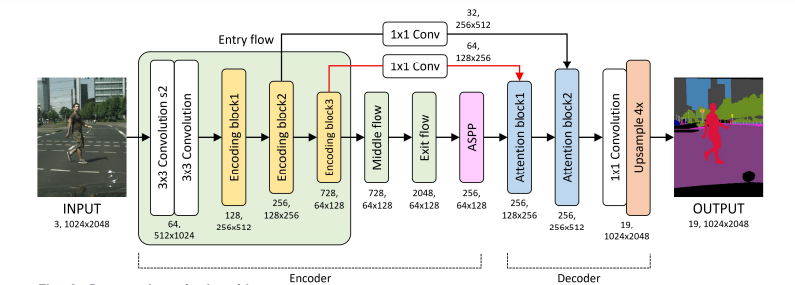

(논문 참조)
https://koreascience.kr/article/JAKO202131452876734.pdf

* 현재 프로젝트에서 사용된  DeepLab V3+로 이 모델의 기능성을 강조하는 방법을 제안하고자 함

> 1. 추가 중간 특징맵을 활용하여 복원 손실을 최소화
> 2. 추가 중간 특징맵을 효과적으로 활용하기 위해 작은 크기의 특징맵부터 계층적 융합
> 3. 디코더에 강조 기법을 적용하여 디코더의 중간 특징맵 융합 능력을 극대화

* **위의 내용 이외**

> 3채널을 가졌던 원본과 다르게 DeepLab V3+이후 채널 정보가 사라졌기 때문에 이 정보를 보충해줄 수 있는 데이터 즉 depth정보를 함께 input해주므로써 분류하고자 하는 대상의 경계를 확실하게 잡아 오차를 줄일 수 있을 것 같습니다.

# 회고

프로젝트 중간 동물 사진의 세그멘테이션된 색상을 변경을 해준다는것을 망각하여 이전 colormap[class_id](사람)부분으로 고양이를 추출하고자 하여 "동물 사진은 원래 이런가?" 라는 생각에 갇혀있다가 다시 오류가 없는지 확인하던 도중에 변경되지 않음을 찾고 문제를 해결함. 

이번 프로젝트는 흔히 포토샵 누끼와 배경처리를 한 작업을
DeepLab V3+ 모델을 통해 바로바로 할 수 있다는 점이 너프하더라고 빠른 결과(크로마키 등)를 얻고자 할때 유용하겠다는 생각이들고 조금만 정확도만 올라간다면 실생활에서도 활용 가치성이 높지 않을까하는 느낌도 받았습니다 